# ChiMEC Radiomics Input and Output Data for Mirai Validation 
This notebook describes the mammogram dataset in ChIMEC used to validate Mirai.
* examines exams available in ChIMEC and characterizes
* filters available metadata and prepares for input into Mirai
* Splits exams into subgroups for subgroup analysis

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np 
from utils.metadata_inspect import print_summary, print_summary2, case_control_prop, \
    prep_full_set, prep_by_race, prep_by_tumor_subtype
import os.path 
import matplotlib.pyplot as plt
import seaborn as sns 

Columns (0,16,17,43,46,50,51,82,108,110,111,135,136,138,140,156,157,158,159,161,176,178,179,180,182,183,184,185,217,221,225,226,229,230,232,233,234,235,236) have mixed types.Specify dtype option on import or set low_memory=False.
Columns (9,13,14,42,47,48,53,58,62,63,65,66,67,69,71,75,111,121,122,123,125,164,182,184,187,189,197,213,228,233,238,240,245,247,252,275,277,279,335,362,368,379,389,399,409,421,452,517,542,567,578,595,605,622,632,649,659,686,713,903,920,930,957,984,1011,1038,1228,1255,1282,1309,1336,1363,1390,1553,1579,1605,1631,1657) have mixed types.Specify dtype option on import or set low_memory=False.


In [2]:
exam_metadata_path= "/gpfs/data/huo-lab/Image/annawoodard/maicara/data/interim/mammo_v9/metadata.pkl"  
#exam level data (does not contain image metadata but has patient and cancer info)
exam_metadata= pd.read_pickle(exam_metadata_path) 
series_metadata_path= "/gpfs/data/huo-lab/Image/annawoodard/maicara/data/interim/mammo_v9/series_metadata.pkl"
series_metadata = pd.read_pickle(series_metadata_path)

In [3]:
full_set, metadata = prep_full_set()

In [4]:
case_control_prop(metadata=metadata)
print_summary(metadata=metadata)

there are 32.88% cases and 67.12% controls
*****AVAILABLE/LOADED***** 
 2141 patients 
 1671 case exams for 704 cases 
 4947 control exams for 1437 controls 
 29381 total entries


ToDo: plot using a cut-flow, the removed exams that pass specified filter criteria

For exams that pass the criteria:

In [5]:
df = metadata.groupby(['unique_exam_id']).first() #keep the first entries

In [6]:
cases= df[df['case']==True]    
cases['years_from_exam_to_diagnosis'].value_counts(dropna=False)

0.093151    11
0.090411    11
0.131507    10
0.082192     8
1.032877     8
            ..
3.986301     1
8.032877     1
0.931507     1
1.947945     1
1.109589     1
Name: years_from_exam_to_diagnosis, Length: 1113, dtype: int64

In [7]:
cases['years_from_exam_to_diagnosis'].describe()

count    1671.000000
mean        2.890763
std         2.125519
min         0.082192
25%         1.179452
50%         2.358904
75%         4.154795
max        10.572603
Name: years_from_exam_to_diagnosis, dtype: float64

In [8]:
controls = cases= df[df['case']== False]    
controls['follow_up_years'].value_counts(dropna=False)

2.030137     9
5.101370     8
3.112329     7
5.830137     7
2.660274     7
            ..
7.232877     1
7.293151     1
7.687671     1
10.104110    1
8.073973     1
Name: follow_up_years, Length: 2694, dtype: int64

In [9]:
controls['follow_up_years'].describe()

count    4947.000000
mean        5.326983
std         2.806808
min         0.276712
25%         3.056164
50%         4.983562
75%         7.453425
max        19.361644
Name: follow_up_years, dtype: float64

In [10]:
df['int_follow_up_years']=df['follow_up_years'].fillna(-1).astype(int)
# if follow_up_years/ years_from_exam_to_diagnosis NaN, replace as -1
df['int_years_from_exam_to_diagnosis']=df['years_from_exam_to_diagnosis'].fillna(-1).astype(int)

In [11]:
controls = cases= df[df['case']== False]    
cases= df[df['case']==True]    


In [12]:
controls['int_follow_up_years'].value_counts(dropna=False)

2     750
3     696
4     596
5     545
6     476
7     426
8     355
9     341
1     287
10    255
0     155
11     54
12      5
19      1
15      1
18      1
17      1
13      1
14      1
Name: int_follow_up_years, dtype: int64

In [13]:
cases['int_years_from_exam_to_diagnosis'].value_counts(dropna=False)

1     384
2     324
0     275
3     229
4     174
5     109
6      93
7      47
8      24
9       9
10      3
Name: int_years_from_exam_to_diagnosis, dtype: int64

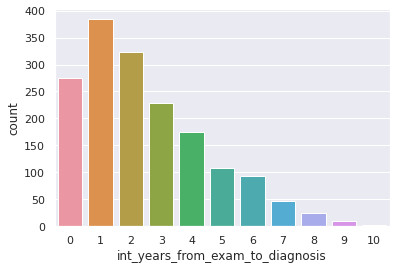

In [14]:
# display distribution of case exams according to years from exam to diagnosis
sns.set(style='darkgrid')
sns.countplot(
    x= 'int_years_from_exam_to_diagnosis', 
    data = cases,
    #order = cases['int_years_from_exam_to_diagnosis'].value_counts().index
)

plt.show()

# bars should be all the same color

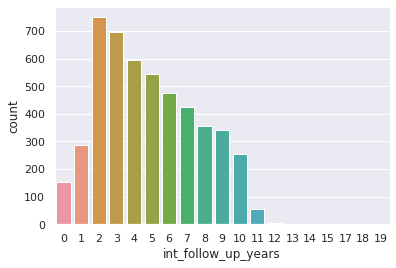

In [15]:
# display distribution of follow-up years for controls
sns.set(style='darkgrid')
sns.countplot(
    x= 'int_follow_up_years', 
    data = controls,
    #order = controls['int_follow_up_years'].value_counts().index
)

plt.show()

In [16]:
# Percentage of control exams with at least 5 years of follow_up information

pass_cut_five = controls[controls['follow_up_years'] >= 5.0]
pass_cut_two = controls[controls['follow_up_years'] >= 2.0]
five_year_cut = len(pass_cut_five) / len(controls) * 100
two_year_cut = len(pass_cut_two) / len(controls) * 100

print('{:.3f} percent of control exams have at least 5 years of follow-up'.format(
    five_year_cut
))
print('{:.3f} percent of controls have at least 2 years of follow-up'.format(
    two_year_cut
))

49.788 percent of control exams have at least 5 years of follow-up
91.065 percent of controls have at least 2 years of follow-up


ToDo: Check if cases exams with less than one year to diagnosis; and control exams with less than one year of follow up are dropped by model.

Controls with just one side- look at periods exam taken

# Mirai input sets preparation and loading  
Sets:
1. Full image set
2. Stratified by race
3. Stratified by tumor subtype
4. Stratified by patient age bins
5. Stratified by breast density

# Full Image Set  

In [30]:
#Save full set to csv for loading 
#full_set.to_csv(path_or_buf= "data/cleaned/full_set_1114.csv")

In [19]:
print_summary2(full_set)

*****AVAILABLE/LOADED***** 
 2141 patients 
 1671 case exams for 704 cases 
 4947 control exams for 1437 controls 
 29381 total entries


# Grouping by race   
Group into White, Black and Others  


In [20]:
data_path = "/gpfs/data/phs/groups/Projects/Huo_projects/SPORE/ojomoleye/data/CRDW_Registry_IndexDx_2020_Jul23.csv"
data = pd.read_csv(data_path)

mrn_to_study_id = pd.read_csv(
    "/gpfs/data/phs/groups/Projects/Huo_projects/SPORE/ojomoleye/data/mrn_to_study_id.csv",
    names=["mrn", "study_id"],
)

downloaded_images = pd.read_pickle(
    "/gpfs/data/phs/groups/Projects/Huo_projects/SPORE/ojomoleye/data/downloaded_imaging_metadata.pkl"
)

cases_and_controls = pd.read_csv(
    "/gpfs/data/phs/groups/Projects/Huo_projects/SPORE/ojomoleye/data/dr_7934_pats.txt",
    sep="|",
)
spore_registration = pd.read_csv(
    "/gpfs/data/phs/groups/Projects/Huo_projects/SPORE/ojomoleye/data/SPORERegistrationDat_DATA_2021-06-21_0927.csv"
)

race_data= pd.read_excel("/gpfs/data/huo-lab/Image/ojomoleye/projects/mirai_validation/data/MRN_to_Race.xls")

Columns (0,16,17,43,46,50,51,82,108,110,111,135,136,138,140,156,157,158,159,161,176,178,179,180,182,183,184,185,217,221,225,226,229,230,232,233,234,235,236) have mixed types.Specify dtype option on import or set low_memory=False.
Columns (9,13,14,42,47,48,53,58,62,63,65,66,67,69,71,75,111,121,122,123,125,164,182,184,187,189,197,213,228,233,238,240,245,247,252,275,277,279,335,362,368,379,389,399,409,421,452,517,542,567,578,595,605,622,632,649,659,686,713,903,920,930,957,984,1011,1038,1228,1255,1282,1309,1336,1363,1390,1553,1579,1605,1631,1657) have mixed types.Specify dtype option on import or set low_memory=False.


889 White - 319 cases and 570 controls 
955 Black - 337 cases and 618 controls 
65 Hispanic - 11 cases and 54 controls 
90 Asian - 31 cases and 59 controls 
5 Native Ame - 1 cases and 4 controls 


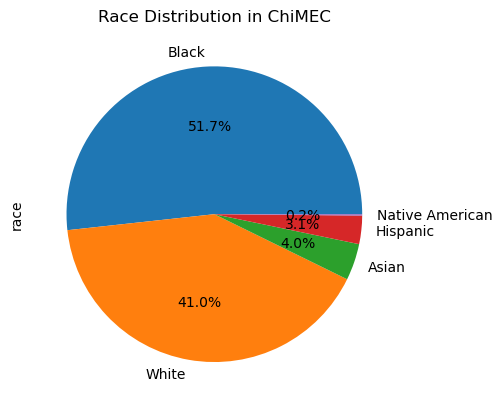


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [21]:
white, black, hispanic, asian_and_native = prep_by_race(df=full_set)

Export full set and race groups for validation

In [34]:
# white.to_csv(path_or_buf= "data/cleaned/white_set_1114.csv")
# black.to_csv(path_or_buf= "data/cleaned/black_set_1112.csv")
# hispanic.to_csv(path_or_buf= "data/cleaned/hispanic_set_1112.csv")
# asian_and_native.to_csv(path_or_buf= "data/cleaned/asiannative_set_1112.csv")

# Grouping by tumor receptor typing


In [35]:
hr_pos, hr_neg, her2_pos, her2_neg, triple_neg = prep_by_tumor_subtype(df=full_set)

there are 1671 unique case exams 
682 unique case exams with tumor type         
40.81388390185518 percent of case exams with tumor type available



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [36]:
hr_pos.to_csv(path_or_buf="data/cleaned/hrpos_set_1114.csv")
# hr_neg.to_csv(path_or_buf="data/cleaned/hrneg_set_1112.csv")
# her2_pos.to_csv(path_or_buf="data/cleaned/her2pos_set_1112.csv")
# her2_neg.to_csv(path_or_buf="data/cleaned/her2neg_set_1112.csv")
triple_neg.to_csv(path_or_buf="data/cleaned/tripleneg_set_1114.csv")

In [37]:
print_summary2(triple_neg)

*****AVAILABLE/LOADED***** 
 37 patients 
 80 case exams for 37 cases 
 0 control exams for 0 controls 
 353 total entries


In [38]:
print_summary2(hr_pos)
print_summary2(hr_neg)

*****AVAILABLE/LOADED***** 
 219 patients 
 555 case exams for 219 cases 
 0 control exams for 0 controls 
 2392 total entries
*****AVAILABLE/LOADED***** 
 50 patients 
 102 case exams for 50 cases 
 0 control exams for 0 controls 
 443 total entries


In [39]:
print_summary2(her2_pos)
print_summary2(her2_neg)

*****AVAILABLE/LOADED***** 
 25 patients 
 57 case exams for 25 cases 
 0 control exams for 0 controls 
 245 total entries
*****AVAILABLE/LOADED***** 
 199 patients 
 500 case exams for 199 cases 
 0 control exams for 0 controls 
 2164 total entries


In [40]:
#reshape dataframe
#https://stackoverflow.com/questions/22798934/pandas-long-to-wide-reshape-by-two-variables
df['idx'] = df.groupby('patient_exam_id').cumcount()

KeyError: 'patient_exam_id'

In [ ]:
#https://stackoverflow.com/questions/22798934/pandas-long-to-wide-reshape-by-two-variables
tmp = []
for var in ['laterality','view', 'file_path']:
    df['tmp_idx'] = var + '_' + df.idx.astype(str)
    tmp.append(df.pivot(index='patient_exam_id',columns='tmp_idx',values=var))

reshape = pd.concat(tmp,axis=1)